In [5]:
from sqlalchemy import create_engine
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

In [7]:
# INGESTION

engine = create_engine("sqlite:///mta_data.db")
df = pd.read_sql('''
SELECT "UNIT" AS unit, "C/A" AS control_area, "SCP" AS scp, "STATION" station, "LINENAME" linename, "DESC" desc, "DATE" date, "TIME" time, "ENTRIES" entries, "EXITS" exits 
FROM mta_data;''', engine) 

pd.read_sql('''
WITH yankees_turnstiles_10 AS (
    SELECT "UNIT" unit, "C/A" control_area, "SCP" scp, "STATION" station, "LINENAME" linename, "DESC" desc, "DATE" date, "TIME" time, "ENTRIES" entries, "EXITS" exits 
    FROM mta_data
    WHERE station = "161/YANKEE STAD";
    GROUPBY unit, control_area, scp, station, linename
    LIMIT 10
)
''', engine)

# date_time, tst_id formulation
df['date_time'] = pd.to_datetime(df['date'] + df['time'], format="%m/%d/%Y%H:%M:%S")
df['turnstile_id'] = df['unit'] + " " + df['control_area'] + " " + df['scp']
df.drop(['control_area','scp'],axis=1,inplace=True)

column_names = ['turnstile_id','unit','station','linename','desc','date_time','date','time','entries','exits']

df = df.reindex(columns=column_names)

df.sort_values(['turnstile_id','date_time'],ascending=[True,False],inplace=True)

# 
df['linename'] = df['linename'].apply(lambda x : ''.join(sorted(x)))
unit_linename = df[['unit','linename','station']].drop_duplicates(subset=['unit','linename','station']).sort_values(['unit'])

# 
station_linename_complex = unit_linename.groupby(['station','linename']).agg({'unit':lambda x: str.join(",", set(x))}).reset_index()
station_linename_complex.sort_values('unit',inplace=True)

unique_units = unit_linename[['unit']].drop_duplicates()
unique_complexes = station_linename_complex[['unit']].drop_duplicates()
unique_complexes.columns = ['complex']

# 
unique_complexes['_'] = 0
unique_units['_'] = 0

unique_complexes = pd.concat([unique_complexes, unique_complexes['complex'].str.split(',', expand=True)], axis=1)

unit_complex_merge = pd.merge(unique_complexes,unique_units).drop("_", axis=1)
unique_complexes.drop("_", axis=1, inplace=True)
unique_units.drop("_", axis=1, inplace=True)

unit_complex = unit_complex_merge[pd.DataFrame(unit_complex_merge['unit']==unit_complex_merge[right_columns] for right_columns in unique_complexes.columns).any()][['unit','complex']]

unit_complex.sort_values('unit',inplace=True)

# Make sure that each unit is only associated with one complex
unit_complex['temp'] = unit_complex['complex'].shift(-1)
unit_complex['temp2'] = unit_complex['complex'].shift(1)


unit_complex['temp'] = unit_complex['temp'].apply(lambda x: set(str(x).split(',')))
unit_complex['temp2'] = unit_complex['temp2'].apply(lambda x: set(str(x).split(',')))


def duplicated_complex(row):
    if row['unit'] == row['complex'] and ((row['complex'] in row['temp']) or (row['complex'] in row['temp2'])):
        return False
    else:
        return True

unit_complex['temp'] = unit_complex.apply(duplicated_complex, axis=1)

unit_complex = unit_complex[unit_complex['temp']==True]
unit_complex.drop(['temp','temp2'],axis=1,inplace=True)
unit_complex.sort_values('unit')

# Add complex as a column based through merge by unit
df = df.merge(unit_complex)
df.drop('unit',axis=1,inplace=True) # Drop unit as it is no longer needed, already accounted for in turnstile_id


df.sort_values(['turnstile_id','station','date_time'],ascending=[True,True,False],inplace=True)

df_daily = (df.groupby(["turnstile_id", "station", "date"],as_index=False).first())

# 
df[["prev_entries", "prev_exits"]] = (df
                                     .groupby(["turnstile_id", "station"])[["entries", "exits"]]
                                     .shift(-1))
df.dropna(subset=["prev_entries",'prev_exits'], axis=0, inplace=True)


df_daily[["prev_entries", "prev_exits"]] = (df_daily
                                     .groupby(["turnstile_id", "station"])[["entries", "exits"]]
                                     .shift(-1))
df_daily.dropna(subset=["prev_entries",'prev_exits'], axis=0, inplace=True)

# 
def get_net_entries(row, max_counter):
    counter = row["entries"] - row["prev_entries"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        # print(f'entries: {row["entries"]} <-- {row["prev_entries"]}')
        counter = min(row["entries"], row["prev_entries"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

def get_net_exits(row, max_counter):
    counter = row["exits"] - row["prev_exits"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        # print(f'entries: {row["exits"]} <-- {row["prev_exits"]}')
        counter = min(row["exits"], row["prev_exits"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

df["net_entries"] = df.apply(get_net_entries, axis=1, max_counter=1600)
df["net_exits"] = df.apply(get_net_exits, axis=1, max_counter=1600)

df["net_traffic"] = df["net_entries"]+df["net_exits"]

df_daily["net_entries"] = df_daily.apply(get_net_entries, axis=1, max_counter=10000)
df_daily["net_exits"] = df_daily.apply(get_net_exits, axis=1, max_counter=10000)

df_daily["net_traffic"] = df_daily["net_entries"]+df_daily["net_exits"]

df.drop(['entries','exits','prev_entries','prev_exits'],axis=1,inplace=True)
df_daily.drop(['entries','exits','prev_entries','prev_exits'],axis=1,inplace=True)

print('finished!')

finished!


In [8]:
def win_loss_ratio(inputstr):
    win_loss = inputstr.split('-')
    if float(win_loss[1]) == 0:
        return float(win_loss[0])
    return float(win_loss[0])/float(win_loss[1])

def get_data(years):
    url = "https://www.baseball-reference.com/teams/NYY/{}-schedule-scores.shtml"
    dfs = []
    for year in years:
        file_url = url.format(year)
        
        schedule = pd.read_html(file_url)[0]
        schedule = schedule[(schedule['Gm#']!='Gm#')&(schedule['Unnamed: 4']!='@')]
        schedule.drop(['Tm','W/L','R','RA','D/N','GB','Unnamed: 2','Unnamed: 4','Inn','Win','Loss','Save','Time','Attendance','Orig. Scheduled'],axis=1,inplace=True)
        schedule['cLI'] = schedule['cLI'].astype(float)
        schedule['Rank'] = schedule['Rank'].astype(int)
        schedule['Streak'] = schedule['Streak'].apply(lambda x: len(x)-1 if x[0]=='+' else -(len(x)-1)).astype(int)
        schedule['Date'] = schedule['Date'].apply(lambda x: re.sub(" \(\d\)", "", x))
        schedule['Date'] = pd.to_datetime(schedule['Date'] + f" {year}",format="%A, %b %d %Y")
        schedule['W-L'] = schedule['W-L'].apply(lambda x: win_loss_ratio(x))
        schedule['W-L'] = schedule['W-L'].astype(float)

        dfs.append(schedule)
    return pd.concat(dfs)

yankees_schedule_data = get_data(['2019'])

In [48]:
yankee_stad = (df[(df['station']=='161/YANKEE STAD')&
                  (df['date_time'].dt.minute==22)]
               .groupby(['date_time','time'])[['net_entries','net_exits','net_traffic']]
               .sum().reset_index())

onesixseven_st_4 = (df[(df['station']=='167 ST')&
                       (df['complex']=='R221')&
                       (df['date_time'].dt.minute==0)]
                    .groupby(['date_time','time'])[['station','linename','net_entries','net_exits','net_traffic']]
                    .sum().reset_index())

onesixseven_st_bd = (df[(df['station']=='167 ST')&
                        (df['complex']=='R104')&
                        (df['date_time'].dt.minute==0)]
                     .groupby(['date_time','time'])[['station','linename','net_entries','net_exits','net_traffic']]
                     .sum().reset_index())

onefournine_st = (df[(df['station']=='149/GRAND CONC')&
                     (df['date_time'].dt.minute==0)]
                  .groupby(['date_time','time'])[['station','linename','net_entries','net_exits','net_traffic']]
                  .sum().reset_index())


In [55]:
home_game_dates = list(yankees_schedule_data['Date'].dt.date)

test_station = onesixseven_st_4

def plot_home_game_effect(test_station, station_name):
    timely_average = test_station.groupby('time')['net_traffic'].mean().reset_index()

    hg_timely_average = (test_station[test_station['date_time'].dt.date.isin(home_game_dates)]
                         .groupby(test_station['time'])['net_traffic'].mean().reset_index())

    xhg_timely_average = (test_station[~test_station['date_time'].dt.date.isin(home_game_dates)]
                          .groupby(test_station['time'])['net_traffic'].mean().reset_index())

    plt.plot(timely_average['time'],
         timely_average['net_traffic'],
         label="All Days")

    plt.plot(hg_timely_average['time'],
             hg_timely_average['net_traffic'],
             label="Home Game Days Only")

    plt.plot(xhg_timely_average['time'],
             xhg_timely_average['net_traffic'],
             label="Non Home Game Days Only")

    plt.xticks(timely_average['time'].drop_duplicates(),labels=['8pm-12am','12am-4am','4am-8am','8am-12pm','12pm-4pm','4pm-8pm'],rotation=45)
    
    
    plt.grid()
    plt.legend(shadow=True)
    plt.xlabel("Time of Day")
    plt.ylabel("Average Net Traffic\n(Entries & Exits)")
    plt.title(f"Daily 4-Hourly Average Traffic\nat {station_name}")
    plt.savefig(f"{station_name}_daily_hourly.png",dpi=200,bbox_inches='tight')
    plt.show()

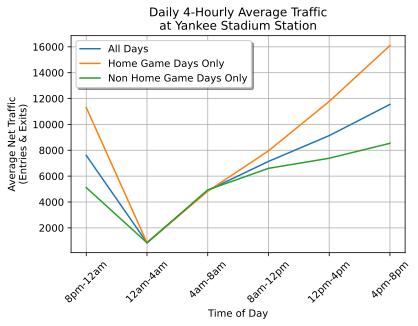

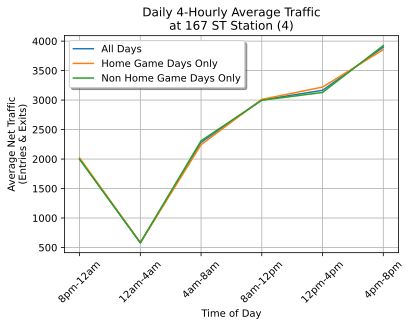

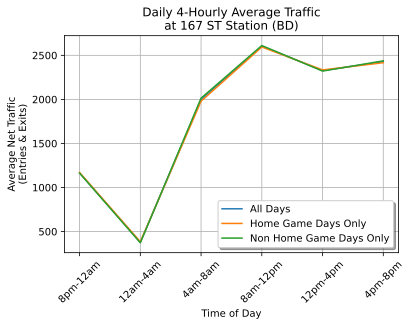

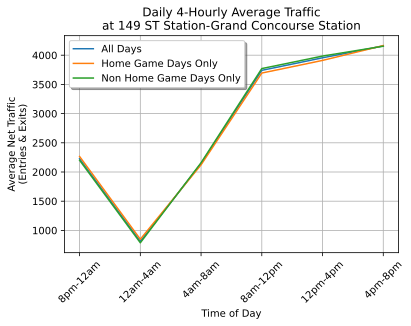

In [56]:
plot_home_game_effect(yankee_stad, "Yankee Stadium Station")
plot_home_game_effect(onesixseven_st_4, "167 ST Station (4)")
plot_home_game_effect(onesixseven_st_bd, "167 ST Station (BD)")
plot_home_game_effect(onefournine_st, "149 ST Station-Grand Concourse Station")

In [20]:
yankee_daily_analysis = (df_daily[(df_daily['station']=='161/YANKEE STAD')&
                                  (df_daily['date_time'].dt.minute==22)]
                         .groupby(df_daily['date'])[['net_entries','net_exits','net_traffic']]
                         .sum().reset_index())

yankee_daily_analysis['Date'] = pd.to_datetime(yankee_daily_analysis['date'], format="%m/%d/%Y")


yankee_daily_analysis = yankee_daily_analysis.merge(yankees_schedule_data,

                                                    how='left')
yankee_daily_analysis['year']=yankee_daily_analysis['Date'].dt.year
yankee_daily_analysis.drop('Date',axis=1,inplace=True)




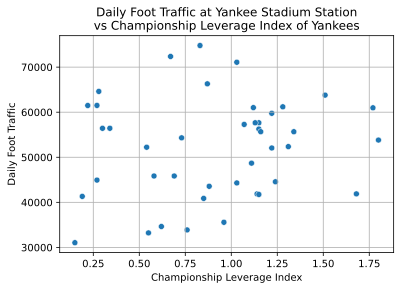

In [21]:
plt.grid()
traffic_cli = sns.scatterplot(x='cLI',y='net_traffic',data=yankee_daily_analysis)
traffic_cli.set(xlabel="Championship Leverage Index",ylabel="Daily Foot Traffic",title="Daily Foot Traffic at Yankee Stadium Station\nvs Championship Leverage Index of Yankees")
plt.savefig("traffic_cli_3months.png",dpi=200)



In [32]:
yankee_daily_analysis[yankee_daily_analysis['W-L'].notna()][['W-L','net_traffic']].reset_index().sort_values('net_traffic')

,index,W-L,net_traffic
41,89,1.930233,31056.0
27,59,1.882353,33225.0
29,69,1.743590,33884.0
26,58,1.939394,34644.0
17,33,1.857143,35581.0
19,50,1.812500,40880.0
40,88,1.976190,41325.0
2,4,1.894737,41753.0
0,2,1.944444,41872.0
10,26,1.703704,41879.0


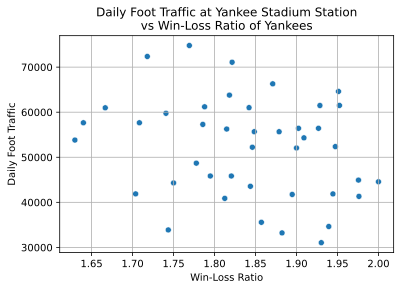

In [29]:
plt.grid()
traffic_wl = sns.scatterplot(x='W-L',y='net_traffic',data=yankee_daily_analysis)
traffic_wl.set(xlabel="Win-Loss Ratio",ylabel="Daily Foot Traffic",title="Daily Foot Traffic at Yankee Stadium Station\nvs Win-Loss Ratio of Yankees")
plt.savefig("traffic_wl_3months.png",dpi=200)


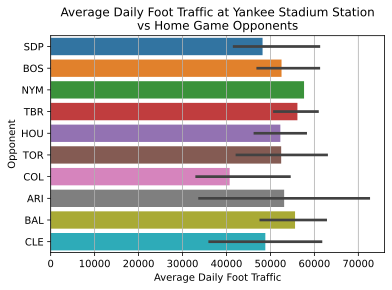

In [23]:
plt.grid()  
traffic_opponent = sns.barplot(y='Opp',x='net_traffic',data=yankee_daily_analysis,)
traffic_opponent.set(ylabel="Opponent",xlabel="Average Daily Foot Traffic",title="Average Daily Foot Traffic at Yankee Stadium Station\nvs Home Game Opponents")
plt.savefig("traffic_opponent_3months.png",dpi=200)